In [1]:
import json
import os
from scene_objects import Scene_Objects
from collections import defaultdict
from grounding import *
import functools

data_dir = "/home/mary/Code/spatial-reasoning/custom_clevr/output/scenes/"
scene_file = "CLEVR_train_000000.json"
output_dir = "/home/mary/Code/spatial-reasoning/relations/"
example_expressions = "/home/mary/Code/spatial-reasoning/relations/example_expressions.json"

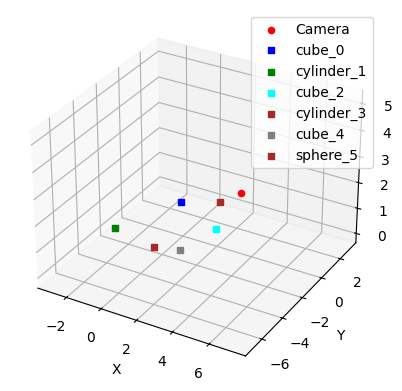

In [2]:
with open(os.path.join(data_dir, scene_file)) as data:
    scene_data = json.load(data)

scene_info = Scene_Objects(scene_data)
entities = scene_info.all_entities

with open(example_expressions) as examples:
    proc_expressions = json.load(examples)


[]
defaultdict(<class 'list'>, {2: [5], 3: [3, 5], 1: [0, 1, 2, 3, 4]})


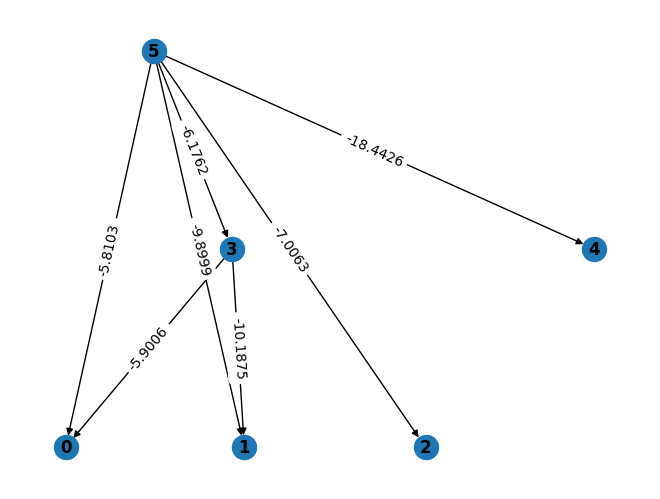

In [3]:

scene_predictor = SpatialPredictor(scene_info)
scene_predictor.relate(proc_expressions[0]['mentions'])
scene_predictor.show_candidate_graph()


TO DO: prune paths that are not feasible \\
if something is a landmark, do not consider it to be a target

In [4]:
# between
# relative distance
# next to
# leaf node with the highest incoming edge scores?
# get rid of candidates dictionary, use stored networkx graph